# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"Data/NYC_Schools/{f}")
    data[key_name] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("Data/NYC_Schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("Data/NYC_Schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall(r"\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall(r"\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined = combined.copy()
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
import matplotlib.pyplot as plt
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
sat_score_survey_corr = combined.corr(numeric_only = True)['sat_score'][survey_fields]
sat_score_survey_corr

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

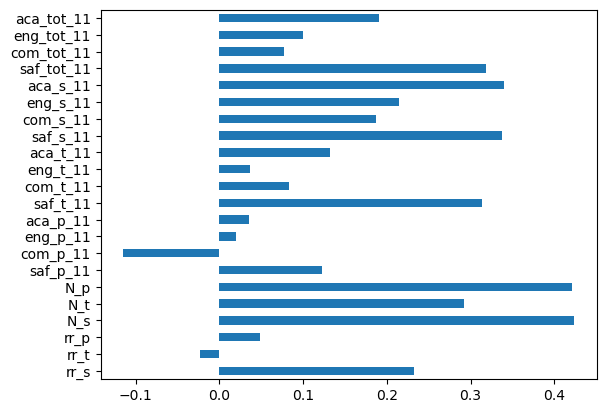

In [11]:
sat_score_survey_corr.plot.barh()
plt.show()

# Exploring Safety and SAT Score

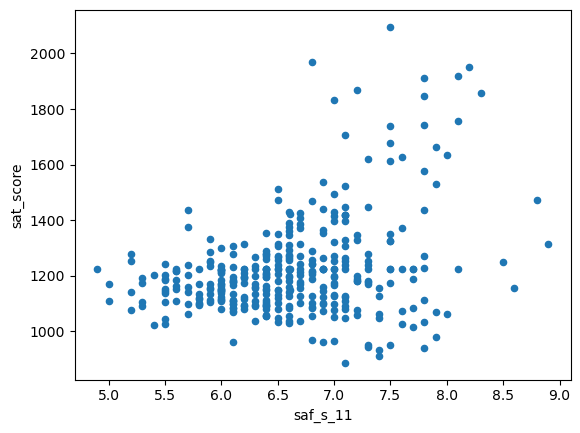

In [12]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')
plt.show()

In [13]:
for i in combined.columns:
    print(i)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

In [14]:
combined['boro'].unique()

array(['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [15]:
sat_score_boro = combined.groupby('boro')['saf_tot_11'].agg('mean').sort_values(ascending = False)
sat_score_boro

boro
Manhattan        7.473333
Queens           7.387500
Bronx            7.322581
Staten Island    7.200000
Brooklyn         7.129245
Name: saf_tot_11, dtype: float64

# Exploring Race and SAT Scores

## Investigating Racial Differences in SAT Scores

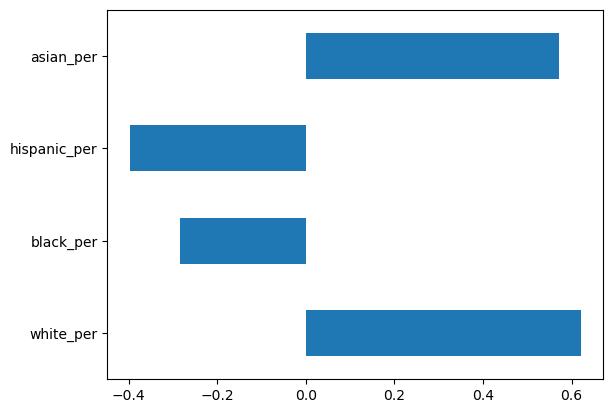

In [16]:
race_pct = ['white_per', 'black_per', 'hispanic_per', 'asian_per']
race_sat_score_corr = combined.corr(numeric_only = True)['sat_score'][race_pct]
race_sat_score_corr.plot.barh()
plt.show()

## Exploring schools with low SAT scores and high values for hispanic_per

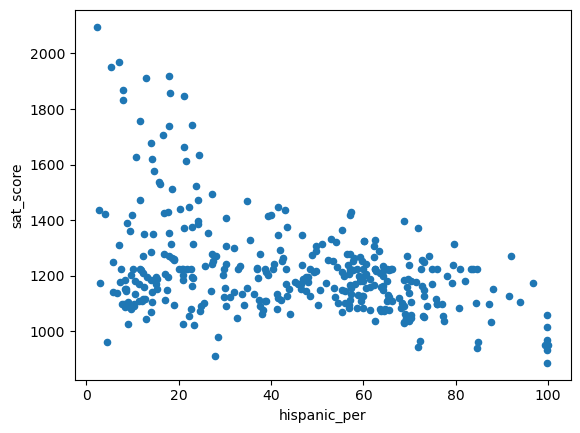

In [17]:
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')
plt.show()

## Schools with a `hispanic_per` greater than 95%

In [18]:
hispanic_per_95_pct = combined[combined['hispanic_per'] > 95]
hispanic_per_95_pct['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Schools with a `hispanic_per` less than 10% and an average SAT score greater than 1800.

In [19]:
hispanic_less_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
hispanic_less_10['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Exploring Gender and SAT Scores

## Gender differences in SAT scores

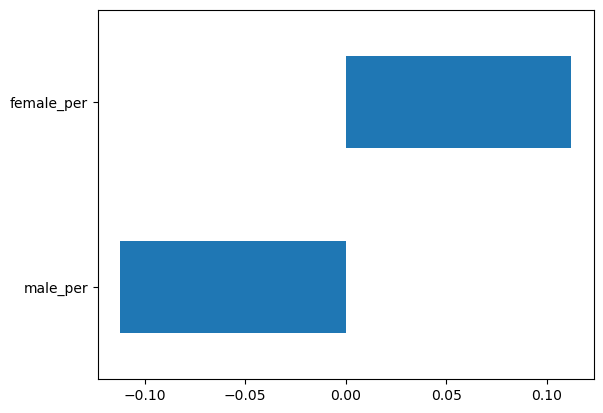

In [20]:
gender_per = ['male_per', 'female_per']
gender_corr = combined.corr(numeric_only = True)['sat_score'][gender_per]
gender_corr.plot.barh()
plt.show()

## Schools with high SAT scores and a high `female_per`

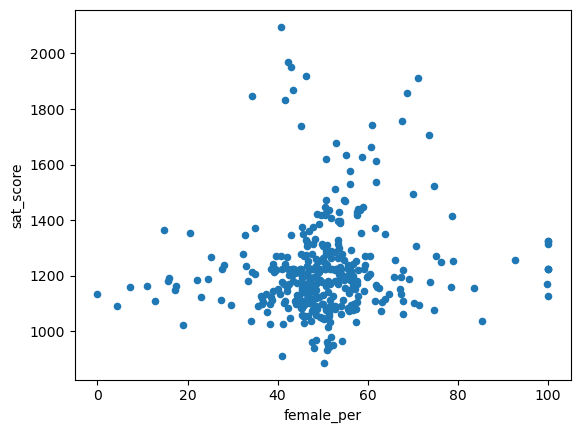

In [21]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')
plt.show()

## Schools with a `female_per` greater than 60% and an average SAT score greater than 1700.

In [22]:
female_per_60 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_per_60['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Exploring AP Scores vs. SAT Scores

## Percentage of students in each school that took an AP exam

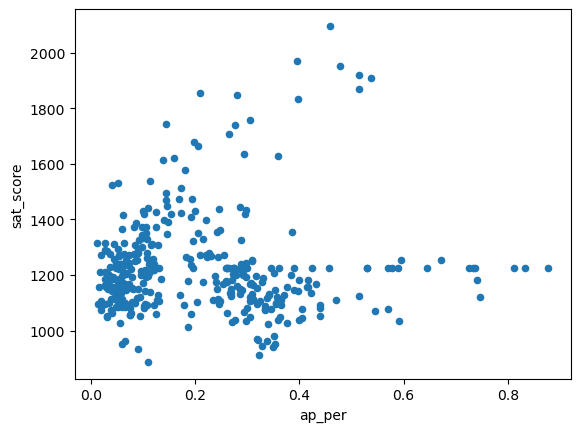

In [23]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x = 'ap_per', y = 'sat_score')
plt.show()